# Image generation with Stable Diffusion XL and OpenVINO

Stable Diffusion XL or SDXL is the latest image generation model that is tailored towards more photorealistic outputs with more detailed imagery and composition compared to previous Stable Diffusion models, including Stable Diffusion 2.1.

With Stable Diffusion XL you can now make more realistic images with improved face generation, produce legible text within images, and create more aesthetically pleasing art using shorter prompts.

![pipeline](https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0/resolve/main/pipeline.png)

[SDXL](https://arxiv.org/abs/2307.01952) consists of an [ensemble of experts](https://arxiv.org/abs/2211.01324) pipeline for latent diffusion: In the first step, the base model is used to generate (noisy) latents, which are then further processed with a refinement model specialized for the final denoising steps. Note that the base model can be used as a standalone module or in a two-stage pipeline as follows: First, the base model is used to generate latents of the desired output size. In the second step, we use a specialized high-resolution model and apply a technique called [SDEdit](https://arxiv.org/abs/2108.01073)( also known as "image to image") to the latents generated in the first step, using the same prompt. 

Compared to previous versions of Stable Diffusion, SDXL leverages a three times larger UNet backbone: The increase of model parameters is mainly due to more attention blocks and a larger cross-attention context as SDXL uses a second text encoder. The authors design multiple novel conditioning schemes and train SDXL on multiple aspect ratios and also introduce a refinement model that is used to improve the visual fidelity of samples generated by SDXL using a post-hoc image-to-image technique. The testing of SDXL shows drastically improved performance compared to the previous versions of Stable Diffusion and achieves results competitive with those of black-box state-of-the-art image generators.

In this tutorial, we consider how to run the SDXL model using OpenVINO.

We will use a pre-trained model from the [Hugging Face Diffusers](https://huggingface.co/docs/diffusers/index) library. To simplify the user experience, the [Hugging Face Optimum Intel](https://huggingface.co/docs/optimum/intel/index) library is used to convert the models to OpenVINO™ IR format.

The tutorial consists of the following steps:

- Install prerequisites
- Download the Stable Diffusion XL Base model from a public source using the [OpenVINO integration with Hugging Face Optimum](https://huggingface.co/blog/openvino).
- Run Text2Image generation pipeline using Stable Diffusion XL base
- Run Image2Image generation pipeline using Stable Diffusion XL base
- Download and convert the Stable Diffusion XL Refiner model from a public source using the [OpenVINO integration with Hugging Face Optimum](https://huggingface.co/blog/openvino).
- Run 2-stages Stable Diffusion XL pipeline

>**Note**: Some demonstrated models can require at least 64GB RAM for conversion and running.

#### Table of contents:
- [Install prerequisites](#Install-prerequisites)
- [SDXL Base model](#SDXL-Base-model)
    - [Select inference device SDXL Base model](#Select-inference-device-SDXL-Base-model)
    - [Run Text2Image generation pipeline](#Run-Text2Image-generation-pipeline)
    - [Text2image Generation Interactive Demo](#Text2image-Generation-Interactive-Demo)
    - [Run Image2Image generation pipeline](#Run-Image2Image-generation-pipeline)
        - [Select inference device SDXL Refiner model](#Select-inference-device-SDXL-Refiner-model)
    - [Image2Image Generation Interactive Demo](#Image2Image-Generation-Interactive-Demo)
- [SDXL Refiner model](#SDXL-Refiner-model)
    - [Select inference device](#Select-inference-device)
    - [Run Text2Image generation with Refinement](#Run-Text2Image-generation-with-Refinement)


## Install prerequisites
[back to top ⬆️](#Table-of-contents:)


In [ ]:
%pip install -q --extra-index-url https://download.pytorch.org/whl/cpu "diffusers>=0.18.0" "invisible-watermark>=0.2.0" "transformers>=4.33.0" "accelerate" "onnx" 
%pip install -q "git+https://github.com/huggingface/optimum-intel.git"
%pip install -q "openvino>=2023.1.0" gradio

## SDXL Base model
[back to top ⬆️](#Table-of-contents:)

We will start with the base model part, which is responsible for the generation of images of the desired output size. 
[stable-diffusion-xl-base-1.0](https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0) is available for downloading via the [HuggingFace hub](https://huggingface.co/models). It already provides a ready-to-use model in OpenVINO format compatible with [Optimum Intel](https://huggingface.co/docs/optimum/intel/index).

To load an OpenVINO model and run an inference with OpenVINO Runtime, you need to replace diffusers `StableDiffusionXLPipeline` with Optimum `OVStableDiffusionXLPipeline`. In case you want to load a PyTorch model and convert it to the OpenVINO format on the fly, you can set `export=True`.  

You can save the model on disk using the `save_pretrained` method.

In [2]:
from pathlib import Path
from optimum.intel.openvino import OVStableDiffusionXLPipeline
import gc

model_id = "stabilityai/stable-diffusion-xl-base-1.0"
model_dir = Path("openvino-sd-xl-base-1.0")

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino


No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
2023-09-19 18:52:15.570335: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-19 18:52:15.609718: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-19 18:52:16.242994: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/ea/work/ov_venv/lib/python3.8/site-packages/transformers/deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please imp

### Select inference device SDXL Base model
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [3]:
import ipywidgets as widgets
import openvino as ov

core = ov.Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

In [4]:
if not model_dir.exists():
    text2image_pipe = OVStableDiffusionXLPipeline.from_pretrained(model_id, compile=False, device=device.value)
    text2image_pipe.half()
    text2image_pipe.save_pretrained(model_dir)
    text2image_pipe.compile()
else:
    text2image_pipe = OVStableDiffusionXLPipeline.from_pretrained(model_dir, device=device.value)

Compiling the vae_decoder...
Compiling the unet...
Compiling the text_encoder...
Compiling the vae_encoder...
Compiling the text_encoder_2...


### Run Text2Image generation pipeline
[back to top ⬆️](#Table-of-contents:)

Now, we can run the model for the generation of images using text prompts. To speed up evaluation and reduce the required memory we decrease `num_inference_steps` and image size (using `height` and `width`).  You can modify them to suit your needs and depend on the target hardware. We also specified a `generator` parameter based on a numpy random state with a specific seed for results reproducibility.

/home/ea/work/ov_venv/lib/python3.8/site-packages/optimum/intel/openvino/modeling_diffusion.py:559: FutureWarning: `shared_memory` is deprecated and will be removed in 2024.0. Value of `shared_memory` is going to override `share_inputs` value. Please use only `share_inputs` explicitly.
  outputs = self.request(inputs, shared_memory=True)


  0%|          | 0/15 [00:00<?, ?it/s]

/home/ea/work/ov_venv/lib/python3.8/site-packages/optimum/intel/openvino/modeling_diffusion.py:590: FutureWarning: `shared_memory` is deprecated and will be removed in 2024.0. Value of `shared_memory` is going to override `share_inputs` value. Please use only `share_inputs` explicitly.
  outputs = self.request(inputs, shared_memory=True)
/home/ea/work/ov_venv/lib/python3.8/site-packages/optimum/intel/openvino/modeling_diffusion.py:606: FutureWarning: `shared_memory` is deprecated and will be removed in 2024.0. Value of `shared_memory` is going to override `share_inputs` value. Please use only `share_inputs` explicitly.
  outputs = self.request(inputs, shared_memory=True)


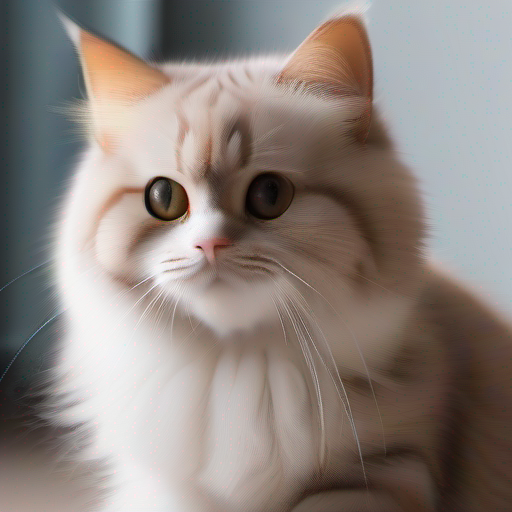

In [5]:
import numpy as np

prompt = "cute cat 4k, high-res, masterpiece, best quality, soft lighting, dynamic angle"
image = text2image_pipe(prompt, num_inference_steps=15, height=512, width=512, generator=np.random.RandomState(314)).images[0]
image.save("cat.png")
image

### Text2image Generation Interactive Demo
[back to top ⬆️](#Table-of-contents:)


In [6]:
import gradio as gr

if text2image_pipe is None:
    text2image_pipe = OVStableDiffusionXLPipeline.from_pretrained(model_dir, device=device.value)

prompt = "cute cat 4k, high-res, masterpiece, best quality, soft lighting, dynamic angle"

def generate_from_text(text, seed, num_steps):
    result = text2image_pipe(text, num_inference_steps=num_steps, generator=np.random.RandomState(seed), height=512, width=512).images[0]
    return result


with gr.Blocks() as demo:
    with gr.Column():
        positive_input = gr.Textbox(label="Text prompt")
        with gr.Row():
            seed_input = gr.Number(precision=0, label="Seed", value=42, minimum=0)
            steps_input = gr.Slider(label="Steps", value=10)
            btn = gr.Button()
        out = gr.Image(label="Result", type="pil", width=512)
        btn.click(generate_from_text, [positive_input, seed_input, steps_input], out)
        gr.Examples([
            [prompt, 999, 20], 
            ["underwater world coral reef, colorful jellyfish, 35mm, cinematic lighting, shallow depth of field,  ultra quality, masterpiece, realistic", 89, 20],
            ["a photo realistic happy white poodle dog ​​playing in the grass, extremely detailed, high res, 8k, masterpiece, dynamic angle", 1569, 15],
            ["Astronaut on Mars watching sunset, best quality, cinematic effects,", 65245, 12],
            ["Black and white street photography of a rainy night in New York, reflections on wet pavement", 48199, 10]
        ], [positive_input, seed_input, steps_input])

# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/
# if you want create public link for sharing demo, please add share=True
demo.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [7]:
demo.close()
text2image_pipe = None
gc.collect();

Closing server running on port: 7860


### Run Image2Image generation pipeline
[back to top ⬆️](#Table-of-contents:)

We can reuse the already converted model for running the Image2Image generation pipeline. For that, we should replace `OVStableDiffusionXLPipeline` with `OVStableDiffusionXLImage2ImagePipeline`.

#### Select inference device SDXL Refiner model
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [8]:
device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

In [9]:
from optimum.intel import OVStableDiffusionXLImg2ImgPipeline

image2image_pipe = OVStableDiffusionXLImg2ImgPipeline.from_pretrained(model_dir, device=device.value)

Compiling the vae_decoder...
Compiling the unet...
Compiling the text_encoder_2...
Compiling the vae_encoder...
Compiling the text_encoder...


/home/ea/work/ov_venv/lib/python3.8/site-packages/optimum/intel/openvino/modeling_diffusion.py:559: FutureWarning: `shared_memory` is deprecated and will be removed in 2024.0. Value of `shared_memory` is going to override `share_inputs` value. Please use only `share_inputs` explicitly.
  outputs = self.request(inputs, shared_memory=True)
/home/ea/work/ov_venv/lib/python3.8/site-packages/optimum/intel/openvino/modeling_diffusion.py:622: FutureWarning: `shared_memory` is deprecated and will be removed in 2024.0. Value of `shared_memory` is going to override `share_inputs` value. Please use only `share_inputs` explicitly.
  outputs = self.request(inputs, shared_memory=True)


  0%|          | 0/7 [00:00<?, ?it/s]

/home/ea/work/ov_venv/lib/python3.8/site-packages/optimum/intel/openvino/modeling_diffusion.py:590: FutureWarning: `shared_memory` is deprecated and will be removed in 2024.0. Value of `shared_memory` is going to override `share_inputs` value. Please use only `share_inputs` explicitly.
  outputs = self.request(inputs, shared_memory=True)
/home/ea/work/ov_venv/lib/python3.8/site-packages/optimum/intel/openvino/modeling_diffusion.py:606: FutureWarning: `shared_memory` is deprecated and will be removed in 2024.0. Value of `shared_memory` is going to override `share_inputs` value. Please use only `share_inputs` explicitly.
  outputs = self.request(inputs, shared_memory=True)


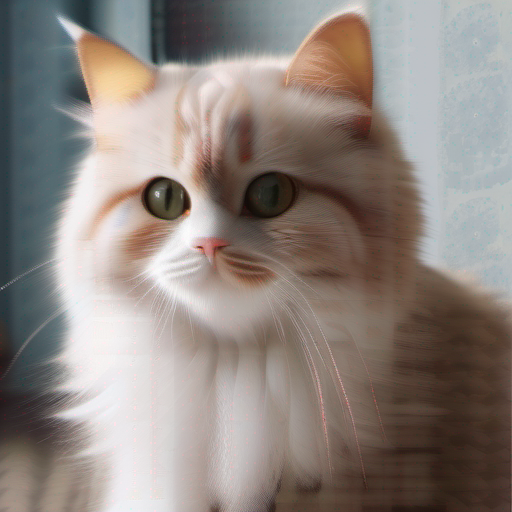

In [10]:
photo_prompt = "professional photo of a cat, extremely detailed, hyper realistic, best quality, full hd"
photo_image = image2image_pipe(photo_prompt, image=image, num_inference_steps=25, generator=np.random.RandomState(356)).images[0]
photo_image.save("photo_cat.png")
photo_image

### Image2Image Generation Interactive Demo
[back to top ⬆️](#Table-of-contents:)


In [11]:
import gradio as gr
from diffusers.utils import load_image
import numpy as np


load_image(
    "https://huggingface.co/datasets/optimum/documentation-images/resolve/main/intel/openvino/sd_xl/castle_friedrich.png"
).resize((512, 512)).save("castle_friedrich.png")


if image2image_pipe is None:
    image2image_pipe = OVStableDiffusionXLImg2ImgPipeline.from_pretrained(model_dir)

def generate_from_image(text, image, seed, num_steps):
    result = image2image_pipe(text, image=image, num_inference_steps=num_steps, generator=np.random.RandomState(seed)).images[0]
    return result


with gr.Blocks() as demo:
    with gr.Column():
        positive_input = gr.Textbox(label="Text prompt")
        with gr.Row():
            seed_input = gr.Number(precision=0, label="Seed", value=42, minimum=0)
            steps_input = gr.Slider(label="Steps", value=10)
            btn = gr.Button()
        with gr.Row():
            i2i_input = gr.Image(label="Input image", type="pil")
            out = gr.Image(label="Result", type="pil", width=512)
        btn.click(generate_from_image, [positive_input, i2i_input, seed_input, steps_input], out)
        gr.Examples([
            ["amazing landscape from legends", "castle_friedrich.png", 971, 60],
            ["Masterpiece of watercolor painting in Van Gogh style", "cat.png", 37890, 40]
        ], [positive_input, i2i_input, seed_input, steps_input])

# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/
# if you want create public link for sharing demo, please add share=True
demo.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [12]:
demo.close()
del image2image_pipe
gc.collect()

Closing server running on port: 7860


280

## SDXL Refiner model
[back to top ⬆️](#Table-of-contents:)

As we discussed above, Stable Diffusion XL can be used in a 2-stages approach: first, the base model is used to generate latents of the desired output size. In the second step, we use a specialized high-resolution model for the refinement of latents generated in the first step, using the same prompt. 
The Stable Diffusion XL Refiner model is designed to transform regular images into stunning masterpieces with the help of user-specified prompt text. It can be used to improve the quality of image generation after the Stable Diffusion XL Base. The refiner model accepts latents produced by the SDXL base model and text prompt for improving generated image.

In [13]:
from optimum.intel import OVStableDiffusionXLImg2ImgPipeline, OVStableDiffusionXLPipeline
from pathlib import Path

refiner_model_id = "stabilityai/stable-diffusion-xl-refiner-1.0"
refiner_model_dir = Path("openvino-sd-xl-refiner-1.0")


if not refiner_model_dir.exists():
    refiner = OVStableDiffusionXLImg2ImgPipeline.from_pretrained(refiner_model_id, export=True, compile=False)
    refiner.half()
    refiner.save_pretrained(refiner_model_dir)
    del refiner
    gc.collect()

### Select inference device
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [14]:
device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

### Run Text2Image generation with Refinement
[back to top ⬆️](#Table-of-contents:)


In [15]:
import numpy as np
import gc
model_dir = Path("openvino-sd-xl-base-1.0")
base = OVStableDiffusionXLPipeline.from_pretrained(model_dir, device=device.value)
prompt = "cute cat 4k, high-res, masterpiece, best quality, soft lighting, dynamic angle"
latents = base(prompt, num_inference_steps=15, height=512, width=512, generator=np.random.RandomState(314), output_type="latent").images[0]

del base
gc.collect()

Compiling the vae_decoder...
Compiling the unet...
Compiling the text_encoder_2...
Compiling the text_encoder...
Compiling the vae_encoder...
/home/ea/work/ov_venv/lib/python3.8/site-packages/optimum/intel/openvino/modeling_diffusion.py:559: FutureWarning: `shared_memory` is deprecated and will be removed in 2024.0. Value of `shared_memory` is going to override `share_inputs` value. Please use only `share_inputs` explicitly.
  outputs = self.request(inputs, shared_memory=True)


  0%|          | 0/15 [00:00<?, ?it/s]

/home/ea/work/ov_venv/lib/python3.8/site-packages/optimum/intel/openvino/modeling_diffusion.py:590: FutureWarning: `shared_memory` is deprecated and will be removed in 2024.0. Value of `shared_memory` is going to override `share_inputs` value. Please use only `share_inputs` explicitly.
  outputs = self.request(inputs, shared_memory=True)


240

In [16]:
refiner = OVStableDiffusionXLImg2ImgPipeline.from_pretrained(refiner_model_dir, device=device.value)


Compiling the vae_decoder...
Compiling the unet...
Compiling the text_encoder_2...
Compiling the vae_encoder...


  0%|          | 0/4 [00:00<?, ?it/s]

/home/ea/work/ov_venv/lib/python3.8/site-packages/optimum/intel/openvino/modeling_diffusion.py:606: FutureWarning: `shared_memory` is deprecated and will be removed in 2024.0. Value of `shared_memory` is going to override `share_inputs` value. Please use only `share_inputs` explicitly.
  outputs = self.request(inputs, shared_memory=True)


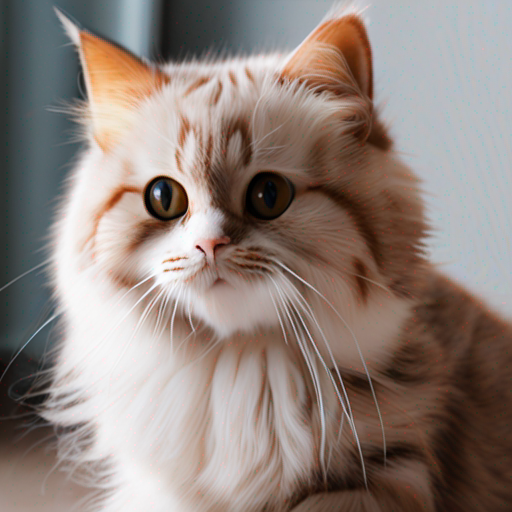

In [17]:
image = refiner(prompt=prompt, image=np.transpose(latents[None, :], (0, 2, 3, 1)), num_inference_steps=15, generator=np.random.RandomState(314)).images[0]
image.save("cat_refined.png")

image